In [1]:
import pandas as pd
import preprocessing as pp
import utils as utils
import numpy as np
from sklearn.naive_bayes import CategoricalNB, GaussianNB
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

In [2]:
import random
seed = 100
np.random.seed(seed)
random.seed(seed)

In [3]:
X, y = utils.importar_datos()

### Modelo 1

- Se utilizan únicamente las variables categóricas genero, tipo_sala y nombre_sede para realizar la clasificación
- Se probó agregando las columnas `edad_isna` y `fila_isna` pero el modelo no mejoró sus resultados.

In [4]:
pipeline_1 = Pipeline([("preprocessor", pp.PreprocessingCategoricalNB1()), 
                     ("model", CategoricalNB())
                     ])

#### Metricas

In [5]:
utils.metricas_cross_validation(X, y, pipeline_1)

,Mean,Std,Oof,Max,Min
roc auc,0.841569,0.028070,0.835868,0.880730,0.795082
accuracy,0.766572,0.020791,0.766542,0.790000,0.730000
precision,0.702750,0.054017,0.693548,0.818182,0.630435
recall,0.700067,0.092606,0.700326,0.789474,0.473684
f1 score,0.694065,0.041590,0.696921,0.740741,0.600000


### Modelo 2

- Se transforman las variables numéricas (precio_ticket y edad) en bins para poder utilizar solamente CategoricalNB.
- Se realizan las mismas transformaciones que en el modelo anterior sobre las variables categóricas.
- Se eliminaron las variables amigos y parientes debido a que no mejoraban el score del modelo.

In [6]:
pipeline_2 = Pipeline([("preprocessor", pp.PreprocessingCategoricalNB2()), 
                     ("model", CategoricalNB())
                     ])

#### Metricas

In [7]:
utils.metricas_cross_validation(X, y, pipeline_2)

,Mean,Std,Oof,Max,Min
roc auc,0.835154,0.031191,0.829874,0.871817,0.784168
accuracy,0.742884,0.033608,0.742821,0.790000,0.693069
precision,0.675134,0.060101,0.668896,0.757576,0.609756
recall,0.651653,0.072225,0.651466,0.763158,0.512821
f1 score,0.659439,0.044341,0.660066,0.704225,0.563380


### Modelo 3

- Se utilizan unicamente las variables continuas y discretas
- Se usa un GaussianNB

In [8]:
pipeline_3 = Pipeline([("preprocessor", pp.PreprocessingGaussianNB1()), 
                     ("model", GaussianNB())
                     ])

#### Metricas

In [9]:
utils.metricas_cross_validation(X, y, pipeline_3)

,Mean,Std,Oof,Max,Min
roc auc,0.682239,0.067797,0.677050,0.738540,0.511885
accuracy,0.667946,0.023888,0.667915,0.690000,0.630000
precision,0.710360,0.093738,0.711340,0.818182,0.555556
recall,0.224949,0.054745,0.224756,0.315789,0.131579
f1 score,0.339075,0.067955,0.341584,0.436364,0.212766


### Modelo 4

- Se combina un CategoricalNB con un GaussianNB usando un GaussianNB que toma la salida de los dos modelos anteriores para realizar la predicción. Para ello se hace un ensamble de tipo Stacking.
- Se buscan mejores hiperparametros que los default con un GridSearchCV para ambos NB

#### Hiperparámetros

In [10]:
pipeline_gaussian = Pipeline([("preprocessor", pp.PreprocessingGaussianNB1()), 
                              ("model", GaussianNB())
                     ])
pipeline_categorical = Pipeline([("preprocessor", pp.PreprocessingCategoricalNB1()), 
                              ("model", CategoricalNB())
                     ])

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'model__alpha': np.arange(1, 10, 1)}

cv = utils.kfold_for_cross_validation()
#Descomentar para ejecutar GridSearchCV
gscv_categorical = GridSearchCV(pipeline_categorical, params, scoring='roc_auc', n_jobs=-1, cv=cv, return_train_score=True).fit(X, y)
print(gscv_categorical.best_score_)
print(gscv_categorical.best_params_)

0.8417277156657254
{'model__alpha': 2}


In [12]:
params = {'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 0.1, 0.3]}

cv = utils.kfold_for_cross_validation()
#Descomentar para ejecutar GridSearchCV
gscv_gaussian = GridSearchCV(pipeline_gaussian, params, scoring='roc_auc', n_jobs=-1, cv=cv, return_train_score=True).fit(X, y)
print(gscv_gaussian.best_score_)
print(gscv_gaussian.best_params_)

0.697344758822778
{'model__var_smoothing': 0.01}


In [13]:
pipeline_gaussian = Pipeline([("preprocessor", pp.PreprocessingGaussianNB1()), 
                              ("model", GaussianNB(var_smoothing=0.01))
                     ])
pipeline_categorical = Pipeline([("preprocessor", pp.PreprocessingCategoricalNB1()), 
                              ("model", CategoricalNB(alpha=2))
                     ])

In [14]:
from sklearn.ensemble import StackingClassifier

estimadores = [('categorical_nb', pipeline_categorical), ('gaussian_nb', pipeline_gaussian)]
cv = utils.kfold_for_cross_validation()

stacked_naive_bayes = StackingClassifier(estimators=estimadores, final_estimator=GaussianNB(), stack_method="predict_proba", cv=cv)

#### Metricas

In [15]:
utils.metricas_cross_validation(X, y, stacked_naive_bayes)

,Mean,Std,Oof,Max,Min
roc auc,0.840878,0.031447,0.832515,0.878608,0.794251
accuracy,0.789059,0.031026,0.789014,0.850000,0.750000
precision,0.792872,0.056105,0.789916,0.925926,0.729730
recall,0.612433,0.077193,0.612378,0.710526,0.473684
f1 score,0.687847,0.057362,0.689908,0.769231,0.590164


### Métricas finales

Se eligió el modelo que utiliza un ensamble de Stacking dado que, si bien el CV dió un poco peor que en el primer modelo del notebook, la diferencia es despreciable. Además al ser un ensamble, el algoritmo puede generalizar mejor.

In [16]:
pipeline_gaussian = Pipeline([("preprocessor", pp.PreprocessingGaussianNB1()), 
                              ("model", GaussianNB(var_smoothing=0.01))
                     ])
pipeline_categorical = Pipeline([("preprocessor", pp.PreprocessingCategoricalNB1()), 
                              ("model", CategoricalNB(alpha=2))
                     ])
estimadores = [('categorical_nb', pipeline_categorical), ('gaussian_nb', pipeline_gaussian)]
cv = utils.kfold_for_cross_validation()

stacked_naive_bayes = StackingClassifier(estimators=estimadores, final_estimator=GaussianNB(), stack_method="predict_proba", cv=cv)

AUC_ROC,Accuracy,Precision,Recall,F1 Score
0.875942,0.818182,0.833333,0.652174,0.731707


Matriz de confusión:


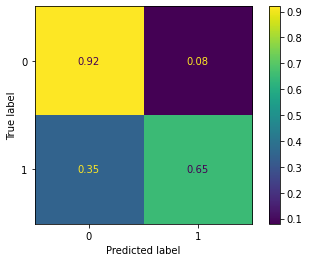

In [17]:
stacked_naive_bayes = utils.entrenar_y_realizar_prediccion_final_con_metricas(X, y, stacked_naive_bayes)

La métrica objetivo AUC-ROC no superó la barrera de 0.90 obtenida en los modelos anteriores basados en arboles. Esto es causa de la alta tasa de Falsos Negativos obtenida por el modelo (7 puntos por encima de la obtenida por RandomForest) lo que afecta a todas las métricas a excepción del Accuracy.

### Predicción HoldOut

In [18]:
utils.predecir_holdout_y_generar_csv(stacked_naive_bayes, 'Predicciones/3-NaiveBayes.csv')